## **Assignment 3: Generative Models [10pts]**

In this assignment we will dive deep into two applications of text generation and one last application of image generation. In the first part we will just work on uncoditioned text generation for generating movie plots.

### **1. Movie Plot Generation [4pts]**
For this part of the assignment we will re-use the dataset from the previous assignment but only use the text part of the dataset. We will train an RNN auto-regressively to generate movie plots.

#### **1.1 Data Loading and Setup**

Same data used in a previous assignment but no images.

In [1]:
# !wget -nc http://www.cs.virginia.edu/~vicente/vislang/mmimdb-noimages.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
!tar xf mmimdb-noimages.tar.gz

--2023-03-16 20:56:07--  http://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz [following]
--2023-03-16 20:56:07--  https://www.cs.rice.edu/~vo9/vislang/mmimdb-noimages.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145318119 (139M) [application/x-gzip]
Saving to: ‘mmimdb-noimages.tar.gz’

mmimdb-noimages.tar 100%[===================>] 138.59M  5.45MB/s    in 27s     

2023-03-16 20:56:34 (5.09 MB/s) - ‘mmimdb-noimages.tar.gz’ saved [145318119/145318119]



#### **1.2 Data Loader Definition**
Unlike the previous assignment here we're writing our own much simpler tokenizer so everything is transparent in its implementation.

In [40]:
import torch, os, json
import numpy as np
from collections import Counter

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, folder = 'dataset', split = 'dev', vocabulary = None):
        self.json_dir = os.path.join(folder, split, 'metadata')

        # Load JSON files.
        print('Loading %s ...' % self.json_dir, end = '')
        fdir = os.listdir(self.json_dir)
        self.metadata = [(fname[:-5], json.load(open(os.path.join(self.json_dir, fname)))) 
                     for fname in sorted(fdir) if not fname.startswith('.')]
        print(' finished')

        # Compute vocabulary.
        if split == 'train':
            texts = " ".join([m[1]['plot'][0] for m in self.metadata])
            word_counts = Counter(texts.lower().split(" "))
            word_counts = sorted(word_counts, key = word_counts.get, reverse = True)
            self.word2id = {w:i for (i, w) in enumerate(word_counts[:20000])}
            self.word2id['<UNK>'] = 20000
            self.word2id['<START>'] = 20000 + 1
            self.word2id['<END>'] = 20000 + 2
            self.word2id['<PAD>'] = 20000 + 3
            self.id2word = {i:w for (w, i) in self.word2id.items()}
        else:
            self.word2id = vocabulary
            self.id2word = {i:w for (w, i) in self.word2id.items()}

        # Pre-tokenizing all sentences.
        print('Tokenizing...', end = '')
        self.tokenized_plots = list()
        for i in range(0, len(self.metadata)):
            text = self.metadata[i][1]['plot'][0]
            encoded_text = self.tokenize(text)
            self.tokenized_plots.append(encoded_text)
        print(' finished')
            
    def __getitem__(self, index: int):
        _, movie_data = self.metadata[index]
        text = self.tokenized_plots[index]
        return text

    def get_metadata(self, index: int):
        _, movie_data = self.metadata[index]
        return movie_data

    def tokenize(self, text):
        text = text.lower().split(" ")
        encoded_text = [self.word2id.get(w, self.word2id['<UNK>']) for w in text]
        encoded_text = encoded_text[:254]
        encoded_text_array = np.ones(256) * self.word2id['<PAD>']
        encoded_text_array[0] = self.word2id['<START>']
        encoded_text_array[1:len(encoded_text) + 1] = encoded_text
        encoded_text_array[len(encoded_text) + 1] = self.word2id['<END>']
        return torch.tensor(encoded_text_array, dtype = torch.long)

    def untokenize(self, token_ids):
        return [self.id2word[id] for id in token_ids.detach().numpy()]

    def __len__(self):
        return len(self.metadata)

train_data = MovieDataset(split = 'train')
val_data = MovieDataset(split = 'dev', vocabulary = train_data.word2id)

text = val_data[1230]
print(text.shape)
print(val_data.untokenize(text))
print('Data size: %d samples' % len(val_data))

Loading dataset/train/metadata ... finished
Tokenizing... finished
Loading dataset/dev/metadata ... finished
Tokenizing... finished
torch.Size([256])
['<START>', 'a', 'gangster', 'boss', '<UNK>', 'has', 'a', 'list', 'of', 'about', '100', 'people', 'who', 'have', '<UNK>', 'up', 'at', 'one', 'point', 'or', 'another.', 'rather', 'than', '<UNK>', 'killing', 'them,', 'he', 'decides', 'to', 'have', 'a', 'little', 'fun', 'by', 'putting', 'all', 'of', 'them', 'together', 'in', 'a', 'high', 'security', 'prison,', '<UNK>', 'and', 'dumping', '<UNK>', 'of', 'guns,', '<UNK>', 'and', 'baseball', 'bats', 'on', 'them', 'and', 'letting', 'them', 'kill', 'each', 'other.', 'the', 'final', 'three', 'who', 'survive', 'are', 'given', 'a', 'prize', 'of', '10', 'million', 'dollars.', 'let', 'chaos', '<UNK>', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>

#### **1.3 Data Loader Usage**
Here we show how to use the data loader to obtain a sample from the training data and show it with reasonable formatting.

In [3]:
import numpy as np
import math

sample_movieID = 2241
text = val_data[sample_movieID]

# Show a plot from the validation set. 
def pretty_print(data: torch.utils.data.Dataset, 
                 token_list: str, 
                 cols: int = 80,
                 hide_padding: bool = True,
                 untokenize_needed = True):
    if untokenize_needed:
        token_list = val_data.untokenize(token_list)
    if hide_padding:
        token_list = [t for t in token_list if t != '<PAD>']
    plot_string = " ".join(token_list)
    for i in range(0, math.ceil(len(plot_string) / cols)):
        print(plot_string[i * cols : (i + 1) * cols])

# Show a movie plot
pretty_print(val_data, text, hide_padding = False)

<START> ruthless executive christine brings on isabelle as her assistant, and sh
e takes delight in <UNK> with the young woman's innocence. but when the <UNK> id
eas become <UNK> enough for christine to pass on as her own, she <UNK> <UNK> amb
ition and cunning -- and the ground is set for all out war. <END> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P
AD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD
> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 
<PAD> <PAD> <PAD> <PAD> <PAD

#### **1.4 Training a Recurrent Neural Network**

First let's define a module in pytorch that uses a recurrent neural network.



In [139]:
import torch.nn as nn
from torch.nn import functional as F

class TextGenerator(nn.Module):
  
    def __init__(self, word_embedding_size: int, 
                 state_size: int, 
                 vocab_size: int):
        super(TextGenerator, self).__init__()
        self.state_size = state_size
        self.num_layers = 3
        
        self.embedding = nn.Embedding(vocab_size, word_embedding_size)
        self.rnn = nn.GRU(word_embedding_size, state_size, batch_first = True, 
                          num_layers = self.num_layers, dropout=0.2)
        self.predictionLayer = nn.Linear(state_size, vocab_size)

    def dummy_input_state(self, batch_size):
        dummy_state = torch.zeros(self.num_layers, batch_size, self.state_size)
        return dummy_state
         
    def forward(self, input_state, input_token_ids):
        # Embed the input token ids into a set of word vectors.
        word_embeddings = self.embedding(input_token_ids)
        
        # Pass the embedding through the RNN.
        output_states, final_output_state = self.rnn(word_embeddings, input_state)
        
        # Output prediction.
        word_scores = self.predictionLayer(output_states)
        
        return word_scores, final_output_state

# Test the model.
generator = TextGenerator(word_embedding_size = 512, 
                          state_size = 1024, 
                          vocab_size = len(val_data.word2id))

generator.eval()
input_state = generator.dummy_input_state(batch_size = 1)

predicted_word_scores, _ = generator(input_state, text.unsqueeze(0)) # why unsqueeze?
predicted_word_scores = F.softmax(predicted_word_scores[0].detach(), dim = 1)

# The model predicts garbage text (of course).
max_scores, predicted_word_ids = predicted_word_scores.max(dim = 1)
print(predicted_word_ids.shape)
print(pretty_print(val_data, predicted_word_ids))

torch.Size([256])
escorts escorts escorts escorts d. d. d. d. outlaw, outlaw, bribed bad. finnish 
henrik chauffeur, chauffeur, may, heart heart worry worry cherished 1930's, 1930
's, man" lush 60's sullivan pursuit, pursuit, pursuit, iconic 1980s meyers count
ryside countryside countryside grueling grueling else's paulie vibrant sensual h
eart heart meetings meetings meetings explosive else's carver carver carver carv
er complex. returning returning gang. gang. newspaper, returning returning carve
r buddha symptoms symptoms symptoms symptoms symptoms bothers bothers outlaw, ou
tlaw, cordier cordier cordier composer composer carver carver sebastian's sebast
ian's jasmine gang. official, official, official, official, official, official, 
official, official, official, official, official, official, official, official, 
official, official, official, official, official, official, official, official, 
official, official, official, official, official, official, official, official, 
official, 

#### **1.5 Training the RNN**
Training the model by feeding it shifted input and output text pairs (Auto-Regressive). Please go back to the slides on Recurrent Neural Networks if needed.

In [6]:
!pip install pytorch-lightning --quiet

import random 
import pytorch_lightning as pl

# The pytorch lighting library requires inheriting from pl.LightingModule.
class TextGeneratorWrapper(pl.LightningModule):
    def __init__(self, textGenerator: TextGenerator, 
                       criterion: nn.Module):
        super().__init__()
        self.textGenerator = textGenerator
        self.learning_rate = 0.001
        self.criterion = criterion 

    # Use the textGenerator forward.
    def forward(self, input_state, input_token_ids):
       return self.textGenerator(input_state, input_token_ids)

    # Define how we treat a batch during training.
    def training_step(self, batch, batch_idx):
        texts = batch

        # Create tensor for the initial input state of the RNN.
        input_state = \
            self.textGenerator.dummy_input_state(batch_size = texts.shape[0])
        input_state = input_state.to(texts.device) # Move to same device as texts e.g. cuda.

        # Compute the predicted texts.
        predicted_texts, _ = self(input_state, texts)
        
        # Define the target texts. These are shifted versions of the input.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        # However we need to collapase the batch and sequence length dimensions.
        num_classes = predicted_texts.shape[2]

        loss = self.criterion(
            predicted_texts[:, :-1, :].contiguous().view(-1, num_classes),
            target_texts.view(-1))
        
        self.log('train_loss', loss, on_epoch = True)
        return loss

    # Very similar to training_step.
    def validation_step(self, batch, batch_idx):
        texts = batch

        # Create tensor for the initial input state of the RNN.
        input_state = \
            self.textGenerator.dummy_input_state(batch_size = texts.shape[0])
        input_state = input_state.to(texts.device) # Move to same device as texts e.g. cuda.

        # Compute the predicted texts.
        predicted_texts, _ = self(input_state, texts)
        
        # Define the target texts. These are shifted versions of the input.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        # However we need to collapase the batch and sequence length dimensions.
        num_classes = predicted_texts.shape[2]

        loss = self.criterion(
            predicted_texts[:, :-1, :].contiguous().view(-1, num_classes),
            target_texts.view(-1))
        
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}
    
    def training_epoch_end(self, outputs):
        loss_mean = torch.stack([x['loss'] for x in outputs]).mean()
        print('Training loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f at epoch %d' %  (loss_mean, self.current_epoch))

    def configure_optimizers(self):
        return [torch.optim.Adam(self.textGenerator.parameters(), 
                                 lr = self.learning_rate)], []

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 7.9 MB/s eta 0:00:00


In [7]:
# Batch size is a liming factor on constrained resources.
# only GPUs with a large memory can hold large batches.
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           pin_memory = True,
                                           num_workers = 12)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size = batch_size, 
                                         shuffle = False,
                                         num_workers = 12)

# Define loss function.
# Cross entropy but ignore predicting the [PAD] token.
cost_function = nn.CrossEntropyLoss(ignore_index = val_data.word2id['<PAD>'])

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Now, here the training loop is greatly simplifed using pytorch lighting. You can even try using TPUs! Or paralellize your training to multiple GPUs very easily.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Callback to save a model checkpoint (weights).
checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/text_generator_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# Create the model.
plotGenerator = TextGenerator(word_embedding_size = 300, 
                          state_size = 512, 
                          vocab_size = len(train_data.word2id))
plotGeneratorWrapper = TextGeneratorWrapper(plotGenerator,
                                            cost_function)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(accelerator = 'gpu', 
                     min_epochs = 20, max_epochs = 20,
                     callbacks = [checkpoint_callback],#
                     limit_train_batches = 1.0, # Use all the data.
                     enable_model_summary = False) 

# # Train the model.
trainer.fit(plotGeneratorWrapper, 
            train_dataloaders = train_loader,
            val_dataloaders = [val_loader]) 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Validation loss 9.91 at epoch 0


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 486: 'val_loss' reached 6.64793 (best 6.64793), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=000-val_loss=6.65.ckpt' as top 1


Validation loss 6.65 at epoch 0
Training loss 6.85 at epoch 0


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 972: 'val_loss' reached 6.61394 (best 6.61394), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=001-val_loss=6.61.ckpt' as top 1


Validation loss 6.61 at epoch 1
Training loss 6.77 at epoch 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1458: 'val_loss' reached 6.51023 (best 6.51023), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=002-val_loss=6.51.ckpt' as top 1


Validation loss 6.51 at epoch 2
Training loss 6.69 at epoch 2


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1944: 'val_loss' reached 6.11929 (best 6.11929), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=003-val_loss=6.12.ckpt' as top 1


Validation loss 6.12 at epoch 3
Training loss 6.46 at epoch 3


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2430: 'val_loss' reached 5.73635 (best 5.73635), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=004-val_loss=5.74.ckpt' as top 1


Validation loss 5.74 at epoch 4
Training loss 6.05 at epoch 4


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2916: 'val_loss' reached 5.50359 (best 5.50359), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=005-val_loss=5.50.ckpt' as top 1


Validation loss 5.50 at epoch 5
Training loss 5.70 at epoch 5


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3402: 'val_loss' reached 5.37144 (best 5.37144), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=006-val_loss=5.37.ckpt' as top 1


Validation loss 5.37 at epoch 6
Training loss 5.47 at epoch 6


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3888: 'val_loss' reached 5.29360 (best 5.29360), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=007-val_loss=5.29.ckpt' as top 1


Validation loss 5.29 at epoch 7
Training loss 5.28 at epoch 7


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 4374: 'val_loss' reached 5.25223 (best 5.25223), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=008-val_loss=5.25.ckpt' as top 1


Validation loss 5.25 at epoch 8
Training loss 5.13 at epoch 8


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 4860: 'val_loss' reached 5.23604 (best 5.23604), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=009-val_loss=5.24.ckpt' as top 1


Validation loss 5.24 at epoch 9
Training loss 4.99 at epoch 9


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 5346: 'val_loss' reached 5.23398 (best 5.23398), saving model to '/content/lightning_logs/version_5/checkpoints/checkpoints/text_generator_weights_epoch=010-val_loss=5.23.ckpt' as top 1


Validation loss 5.23 at epoch 10
Training loss 4.86 at epoch 10


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 5832: 'val_loss' was not in top 1


Validation loss 5.25 at epoch 11
Training loss 4.73 at epoch 11


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 6318: 'val_loss' was not in top 1


Validation loss 5.27 at epoch 12
Training loss 4.59 at epoch 12


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 6804: 'val_loss' was not in top 1


Validation loss 5.31 at epoch 13
Training loss 4.46 at epoch 13


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 7290: 'val_loss' was not in top 1


Validation loss 5.34 at epoch 14
Training loss 4.34 at epoch 14


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 7776: 'val_loss' was not in top 1


Validation loss 5.38 at epoch 15
Training loss 4.22 at epoch 15


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 8262: 'val_loss' was not in top 1


Validation loss 5.42 at epoch 16
Training loss 4.12 at epoch 16


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 8748: 'val_loss' was not in top 1


Validation loss 5.46 at epoch 17
Training loss 4.02 at epoch 17


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 9234: 'val_loss' was not in top 1


Validation loss 5.51 at epoch 18
Training loss 3.93 at epoch 18


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 9720: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Validation loss 5.55 at epoch 19
Training loss 3.85 at epoch 19


#### **1.6 Re-Using a Pretrained Model**
I have a model ready for you to use posted online. Feel free to use this instead of running the training code above.

In [60]:
# Create the model.
plotGenerator = TextGenerator(word_embedding_size = 300, 
                          state_size = 256, 
                          vocab_size = len(train_data.word2id))
plotGeneratorWrapper = TextGeneratorWrapper(plotGenerator,
                                            cost_function)

# Remember wget -nc makes sure you don't download the file twice if already downloaded.
# !wget -nc http://www.cs.virginia.edu/~vicente/vislang/text_generator_weights_epoch\=011-val_loss\=1.72.ckpt
!wget -nc http://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch\=011-val_loss\=1.72.ckpt
#!wget -nc http://www.cs.rice.edu/~vo9/vislang/text_generator_weights_epoch\=015-val_loss\=5.20.ckpt
checkpoint = torch.load('text_generator_weights_epoch=011-val_loss=1.72.ckpt')
#checkpoint = torch.load('checkpoints/text_generator_weights_epoch=015-val_loss=5.21.ckpt')
plotGeneratorWrapper.load_state_dict(checkpoint['state_dict'])

File ‘text_generator_weights_epoch=011-val_loss=1.72.ckpt’ already there; not retrieving.



<All keys matched successfully>

#### **1.7 Generating a Movie plots [4pts]**

##### **1.7.1 Next Token Prediction**

First let's see what the model has learned to predict next to an input <START> token.

In [180]:
# Always set network in eval mode.
plotGenerator.eval()

# Try modifying the temperature and see what it does to both
# the probability scores and the next token prediction.
# What happens when you set it to 0.5? What if you set it to 1.0?
kTemperature = 0.9

# Create input token.
token = 'a'
# Keep in mind we have to add a dummy sequence dimension.
input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

# Create the input state h_0 for the RNN.
input_state = plotGenerator.dummy_input_state(batch_size = 1)

# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))

# Take the output predictions from the LSTM for the next token.
# Apply the softmax and let's use a kTemperature parameter here.
next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
next_token_scores = next_token_scores.detach().clone()

# Let's sort the scores in descending order and show the top scored words.
sorted_token_scores, sorted_token_ids = next_token_scores.sort(dim = 0, descending = True)
for (token, score) in zip(sorted_token_ids[:12], sorted_token_scores[:12]):
    print('P[%s] = %.4f' % (val_data.id2word[token.item()], score.item()))

# Now let's sample a token using the probability scores.
# Please see the numpy documentation for np.random.choice.
next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
print('\nGenerated next token following <START>: \"%s\"' % val_data.id2word[next_token_id])

P[handful] = 0.0058
P[sudden,] = 0.0031
P[botched] = 0.0026
P[lot] = 0.0025
P[litter] = 0.0022
P[24-hour] = 0.0019
P[few] = 0.0018
P[series] = 0.0018
P[flourishing] = 0.0017
P[bunch] = 0.0017
P[prestigious] = 0.0016
P[scathing] = 0.0016

Generated next token following <START>: "high-profile"


##### **1.7.2 Full Movie Plot Generation [2pts]**.

Write code here that generates a complete Movie Plot from this trained RNN. I'm showing below an example of a movie plot (using kTemperature = 0.9).


In [163]:
# Always set network in eval mode.
plotGenerator.eval()
kTemperature = 0.9
# Create input token.
token = '<START>'
predicted_word_ids = [val_data.word2id[token]]
input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)
input_state = plotGenerator.dummy_input_state(batch_size = 1)
plot = '<START>'
# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.
for idx in range(256):
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))
  next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
  next_token_scores = next_token_scores.detach().clone()
  sorted_token_scores, sorted_token_ids = next_token_scores.sort(dim = 0, descending = True)
  input_state = next_state
  #print(sorted_token_scores)
  next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
  #print(next_token_id)
  if val_data.id2word[next_token_id] != "<PAD>":
    input_token = torch.tensor(next_token_id).unsqueeze(0)
    #print(val_data.id2word[next_token_id])
    next_word = val_data.id2word[next_token_id]
    #print(next_token_id,predicted_word_ids[-1],val_data.id2word[next_token_id])
    if predicted_word_ids[-1] != next_token_id:
      predicted_word_ids.append(next_token_id)
  else:
    input_token = torch.tensor(sorted_token_ids[1]).unsqueeze(0)
    #print("PAD",val_data.id2word[sorted_token_ids[1].item()])
    next_word = val_data.id2word[sorted_token_ids[1].item()]
    predicted_word_ids.append(sorted_token_ids[1])

  if next_word == "<END>":
    break

print(pretty_print(val_data, torch.tensor(predicted_word_ids)))

<START> in today's <UNK> district, <UNK> avid <UNK> the mine is <UNK> in the bri
tish desert, election, the film focuses composed of the history of british japan
ese city <UNK> that portrayed a national loving tale and the future, <UNK> who l
ives in a glimpse <UNK> in northern <UNK> we follow the <UNK> terrorist <UNK> an
d actor <UNK> charming <UNK> lisa <UNK> and <UNK> met e <UNK> and his friends ar
e loved by it's a <UNK> hasan, of <UNK> a classic group of a cultural <UNK> thei
r production <UNK> into the music <UNK> house, <UNK> and <UNK> developing the fi
rst dark fine <UNK> progress by a fleet of <UNK> friendship and <UNK> raoul weal
thy <UNK> records. <UNK> and <UNK> came around in a new house the girl appears <
UNK> as the <UNK> boys and sunset close boarding for viewers - a <UNK> leads a <
UNK> on the healing world, behind the way and the well-being of <UNK> media <UNK
> who includes a loyal wet <UNK> to turn from <UNK> to <UNK> the native <UNK> is
 the cast of the <UNK> head,

##### **1.7.3 Generate a Movie Plot using a Prompt [2pts]**

Now write code to generate a movie plot that start as follows:

"A woman starts a journey..."

Make your code general enough to accept any arbitrary starting phrase.

In [187]:
# Always set network in eval mode.
plotGenerator.eval()
kTemperature = 0.95
predicted_word_ids = []
# Create input token.
input_tokens = " A woman starts a journey"
input_list = input_tokens.split()
input_state = plotGenerator.dummy_input_state(batch_size = 1)

for idx in input_list:
  idx = idx.lower()
  input_token = torch.tensor(val_data.word2id[idx]).unsqueeze(0)
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))
  input_state = next_state
  predicted_word_ids.append(val_data.word2id[idx])

token = input_list[-1]
input_token = torch.tensor(val_data.word2id[token]).unsqueeze(0)

for idx in range(256):
  predicted_tokens, next_state = plotGenerator(input_state, input_token.unsqueeze(0))
  next_token_scores = predicted_tokens[0, -1, :].detach().div(kTemperature).softmax(dim = 0)
  next_token_scores = next_token_scores.detach().clone()
  sorted_token_scores, sorted_token_ids = next_token_scores.sort(dim = 0, descending = True)
  input_state = next_state
  #print(sorted_token_scores)
  next_token_id = np.random.choice(len(next_token_scores), p = next_token_scores.numpy())
  #print(next_token_id)
  if val_data.id2word[next_token_id] != "<PAD>":
    input_token = torch.tensor(next_token_id).unsqueeze(0)
    #print(val_data.id2word[next_token_id])
    next_word = val_data.id2word[next_token_id]
    #print(next_token_id,predicted_word_ids[-1],val_data.id2word[next_token_id])
    if predicted_word_ids[-1] != next_token_id:
      predicted_word_ids.append(next_token_id)
  else:
    input_token = torch.tensor(sorted_token_ids[1]).unsqueeze(0)
    #print("PAD",val_data.id2word[sorted_token_ids[1].item()])
    next_word = val_data.id2word[sorted_token_ids[1].item()]
    predicted_word_ids.append(sorted_token_ids[1])

  if next_word == "<END>":
    break

print(pretty_print(val_data, torch.tensor(predicted_word_ids)))



# Predict the next token softmax scores.
# Keep in mind we have to add a dummy batch dimension.

a woman starts a journey award as the europe explores convicted which has been d
rinking eyes for a <UNK> he is invited to disguise with some of his patients. co
ntinue threatened with a wall around retaliation betraying a group of facts he o
ften sets off on an adventure as a prisoner which shows the mythic scrutiny of a
n underground warden attempt, along by civil the response, he gets a change, as 
he becomes the words. the <UNK> beneath the local <UNK> then is trying to destro
y us at his training life. <END>
None


### **2. Image Captioning [4pts]**
The objective of this project is to create an image captioning system consisting of a CNN connected to an RNN to describe images in German. We will rely on the Multi30k dataset containing images with captions in German.

#### **2.1. Download Resources and Setup the Environment**

In this part of the assignment we will work with the Multi30k dataset, this dataset was created by a team at the University of Sheffield, University of Copenhagen and the University of Edinburgh. You can find their repository here https://github.com/toshohirasawa/multi30k.

The dataset has 30,000 images from a previous dataset called Flickr30k which was collected earlier by a team at the University of Illinois. However, Multi30k contains image descriptions in German, French, English and Czech. We will use Task2 from this dataset which contains only German and English. We will focus on German in this assignment.



In [1]:
# Download data for the flickr30k dataset and multi30k dataset.
#!wget -nc http://www.cs.virginia.edu/~vicente/vislang/flickr30k-images-small.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz
!tar xf flickr30k-images-small.tar.gz
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset
!gunzip multi30k-dataset/data/task2/raw/*.gz
!gunzip multi30k-dataset/data/task2/tok/*.gz
!mkdir cache
# Concatenate five captions for each image
!paste -d "\n" multi30k-dataset/data/task2/raw/train.*.de > multi30k-dataset/data/task2/raw/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/val.*.de > multi30k-dataset/data/task2/raw/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/test_2016.*.de > multi30k-dataset/data/task2/raw/test_2016.all.de
# Use tokens instead of raw data
!paste -d "\n" multi30k-dataset/data/task2/tok/train.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/val.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/test_2016.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/test_2016.all.de


File ‘flickr30k-images-small.tar.gz’ already there; not retrieving.

fatal: destination path 'multi30k-dataset' already exists and is not an empty directory.
gzip: multi30k-dataset/data/task2/raw/*.gz: No such file or directory
gzip: multi30k-dataset/data/task2/tok/*.gz: No such file or directory
mkdir: cannot create directory ‘cache’: File exists


In [2]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-lightning==1.9.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **2.2 Define the Dataset Class for Multi30k**

As usual, we need to create a torch.utils.data.dataset.Dataset class to load our data so we can pass this class to pytorch's batch data loaders. 

In [4]:
import torch
import torchtext
import pandas, os, pickle
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from filelock import FileLock

class Multi30kDataset(Dataset):
    def __init__(self, tokenizer, 
                 dataset_file_path: str, # location of the multi30k local cloned repo.
                 image_file_path: str, # location of the flickr30k images.
                 split: str, # train, val, test_2016
                 language: str, # en, de
                 vocabulary_size: int,
                 image_transform = None,
                 cache_path = None,
                 overwrite_cache = False):
        
        assert os.path.exists(dataset_file_path), dataset_file_path
        assert os.path.exists(image_file_path), image_file_path
        assert language in ['en', 'de'], 'invalid language'
        assert split in ['val', 'train', 'test_2016'], 'invalid split'
        assert cache_path, 'provide a writtable cache path'
        assert vocabulary_size > 0
        
        self.image_file_path = image_file_path
        self.language = language
        self.split = split
        self.image_transform = image_transform
        self.textTokenizer = tokenizer
        
        # Open split file.
        data_filenames = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/image_splits/', '%s_images.txt' % self.split),
            header = None)

        # Open raw text file.
        
        data_text = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/tok/', '%s.all.%s' % (self.split, self.language)),
            header = None, sep = '\t\n')
         
        # Tokenize and add examples to the local variables.
        self.images = [image_filename for image_filename in data_filenames[0]]
            
        # Cache directory file.
        cached_features_file = os.path.join(
            cache_path, "cached_toks_{}_{}_{}".format(tokenizer.__class__.__name__, self.split, self.language))
        
        # In case of multi-threaded execution and to avoid recomputing this all the time.
        lock_path = cached_features_file + ".lock"
        with FileLock(lock_path):
            if os.path.exists(cached_features_file) and not overwrite_cache:
                with open(cached_features_file, "rb") as handle:
                    self.texts = torch.load(handle)
            else:
                # Tokenize and add examples to the local variables.
                self.texts = list()
                self.images = list()
                for (ii, caption) in tqdm(enumerate(data_text[0])):
                    # if ii > 999:break
                    tokenized_caption = tokenizer.preprocess(caption)
                    self.texts.append(tokenized_caption)
                    # Every image has five captions
                    self.images.append(data_filenames[0][ii//5])
            
                # If needed build the tokenizer vocabulary.
                if self.split == "train" and not hasattr(tokenizer, "vocab"):
                    tokenizer.build_vocab(self.texts, max_size = vocabulary_size)

                # Numericalize all texts.
                for i in tqdm(range(0, len(self.texts))):
                    self.texts[i] = tokenizer.process([self.texts[i]])
                    
                # Save processed texts.
                with open(cached_features_file, "wb") as handle:
                    torch.save(self.texts, handle)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        image = Image.open(os.path.join(self.image_file_path, self.images[i])).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image) 
        return image, self.texts[i].squeeze()
    
    # To be used in the Data Loader collate_fn parameter.
    def create_batch(self, batch):
        images, texts = zip(*batch)

        # Compute text lengths for Pytorch's RNN library.
        text_lengths = [len(text) for text in texts]

        # Stack images and pad text.
        stacked_images = torch.stack(images)
        padded_texts = pad_sequence(texts, batch_first = self.textTokenizer.batch_first, 
                                    padding_value = self.textTokenizer.vocab.stoi["<pad>"])

        return stacked_images, padded_texts, text_lengths
    

#### **2.3 Example usage of the Multi30k Dataset class**

Here we just test that our dataset class and pytorch data loaders are working. We are also using here python's ArgumentParser to define hyperparameters.

In [5]:
import os
import argparse
import torch
import torchtext
import torchtext.data
import torchvision.transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('--language', type =  str,
                    default = 'de', help = 'Language to load')
parser.add_argument('--max_vocabulary_size', type =  int,
                    default = 12000, help = 'Vocabulary size to use')
parser.add_argument('--dataset_path', type =  str, default = 'multi30k-dataset',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--images_path', type =  str, default = 'flickr30k-images-small',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--cache_path', type =  str, default = 'cache',
                    help = 'path to cached data files')

config, _ = parser.parse_known_args()

# Create the tokenizer for this language and model.
textTokenizer = torchtext.data.Field(sequential = True,
                                            init_token = "<start>", eos_token = "<end>", 
                                            pad_token = "<pad>", unk_token = "<unk>",
                                            batch_first = True)
    
# Create image transforms using standard Imagenet-based model transforms.
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

# Create dataset classes for training and validation.
trainset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                   'train', config.language, config.max_vocabulary_size,
                                   image_transform =  train_transform,
                                   cache_path = config.cache_path, overwrite_cache = True)
valset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                 'val', config.language, config.max_vocabulary_size,
                                 image_transform = test_transform,
                                 cache_path = config.cache_path, overwrite_cache = True)

<ipython-input-4-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
145000it [00:01, 83002.40it/s]
100%|██████████| 145000/145000 [00:07<00:00, 19552.67it/s]
<ipython-input-4-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
5070it [00:00, 109739.61it/s]
100%|██████████| 5070/5070 [00:00<00:00, 68566.20it/s]


In [6]:
# Test the dataset class for the validation set, show an image and a caption.
print('len(dataset)', len(valset))
image, caption = valset[44]
print(image.shape, caption.shape)

len(dataset) 5070
torch.Size([3, 224, 224]) torch.Size([12])


In [7]:
#input = [textTokenizer.preprocess("D'avantage on peut dire que c'est hommexd est grand")]
input = [textTokenizer.preprocess("Eine Frau laufen für das Haus".lower())]
# input = [textTokenizer.preprocess("My brother looked up the window and realized there was a bird")]
tensor = textTokenizer.process(input)
print(tensor)
print(textTokenizer.vocab.stoi["<unk>"])

tensor([[  2,  10,  16,  87, 229,  45, 180,   3]])
0


In [8]:
# Now to data loaders and batch building.
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = 128, 
                                           num_workers = 2,
                                           shuffle = True,
                                           collate_fn = trainset.create_batch)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = 128, 
                                         num_workers = 2,
                                         shuffle = False,
                                         collate_fn = valset.create_batch)
(images, texts, text_lengths) = next(iter(val_loader))

print(images.shape, texts.shape, text_lengths)

torch.Size([128, 3, 224, 224]) torch.Size([128, 29]) [5, 11, 11, 14, 11, 9, 9, 8, 12, 9, 10, 12, 16, 14, 14, 6, 11, 9, 9, 11, 10, 8, 10, 11, 16, 8, 12, 14, 11, 12, 15, 10, 9, 8, 11, 8, 8, 7, 14, 14, 14, 12, 16, 12, 12, 8, 18, 13, 11, 8, 9, 9, 10, 9, 13, 9, 12, 9, 12, 8, 10, 12, 14, 14, 23, 7, 10, 11, 24, 13, 10, 11, 9, 22, 16, 11, 9, 10, 17, 12, 8, 10, 11, 9, 16, 11, 9, 9, 11, 15, 13, 13, 11, 7, 12, 11, 9, 12, 10, 7, 8, 18, 29, 16, 22, 7, 9, 8, 12, 12, 5, 12, 15, 17, 15, 9, 24, 9, 14, 11, 9, 9, 8, 8, 16, 9, 10, 9]


#### **2.4. Create and test the ImageEncoder**

As models get complicated it is perhaps a good idea to break down a model into several nn.Module's. So here we just define the Image Encoder that uses a CNN to convert the image into a vector. 

In [9]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.base_network.layer1(x)
            x = self.base_network.layer2(x)
            x = self.base_network.layer3(x)
            x = self.base_network.layer4(x)
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap


In [10]:
image_encoder = ImageEncoder(512)
image_encoder.eval()
encoded_images = image_encoder(images)
print(encoded_images.shape)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([128, 512])


#### **2.5. Create and test the TextDecoder**

Now we create the text decoder class that will take as input the image encoder output and use an RNN to create a sentence in auto-regressive mode.

In [11]:
import torch.nn as nn
from torch.nn import functional as F


class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)



In [12]:
# Example usage.
text_decoder = TextDecoder(300, 512, len(textTokenizer.vocab))

# Pick the first token of the text batch (after the <start> token).
sample_input_token = texts[:, 1]
batch_size = texts.shape[0]
initial_state = text_decoder.dummy_input_state(batch_size)

# Compute prediction in current time step and state vector for next time step.
prediction, output_state = text_decoder(initial_state, sample_input_token)

# Print the shape of the next token prediction (for each sequence in the batch)
print("next token prediction: ", prediction.shape)

next token prediction:  torch.Size([128, 12004])


#### **2.6. Define the ImageCaptioner class and test it.**

Here we put the previous two things together and create an Image Captioner model that connects the ImageEncoder and TextDecoder.

In [31]:
import random 
import pytorch_lightning as pl

# Image Captioning module.
# Using pytorch-lightning for simplicity.

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer.vocab)
        self.padding_token_id = textTokenizer.vocab.stoi["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, lengths = batch

        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)
        
        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts, lengths = batch

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()

        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []


#### **2.7. Training Loop**

Here we have the training loop which has been greatly simplified by the use of the Pytorch Lighting library.

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filename = 'checkpoints/image_captioner_weights_{epoch:03d}-{val_loss:.2f}',
    verbose = True, monitor = 'val_loss', mode = 'min', save_top_k = 1)

# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer)

# # Simple thanks to Pytorch Lighting.
trainer = pl.Trainer(gradient_clip_val = 1.0, gpus = 1, 
                     min_epochs = 5, max_epochs = 10,
                     callbacks = [checkpoint_callback],
                     enable_model_summary = False) 

# # Train the model.
trainer.fit(image_captioner, 
            train_dataloaders = train_loader, 
            val_dataloaders = [val_loader]) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: Tru

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation loss 9.39


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


#### **2.8. Generate some Captions for a group of Images. [4pts]**

This is the second graded part of the assignment where you have to use the model we just trained above and use it to generate captions for a group of images specified below. You have to do so by using the trained ImageEncoder and TextDecoder. For each image you will have to obtain the output of the ImageEncoder and then supply this output to the TextDecoder to predict the first token of the output sentence (maximally scored token), then you provide this token back to the RNN to predict the following token (maximally scored token) and so on, until the [END] token is predicted or a maximum length is reached (max: 128). **Note:** For decoding with the RNN you have to be careful to be passing the state vectors of the RNN (GRU in this case) so the history of previously generated tokens is used.

In [15]:
# Download the checkpoint
# !wget -nc https://www.cs.virginia.edu/~zy3cx/image_captioner_weights.ckpt
!wget -nc https://www.cs.rice.edu/~vo9/vislang/image_captioner_weights.ckpt

# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer)

# Load the pre-trained model
checkpoint = torch.load('image_captioner_weights.ckpt')
image_captioner.load_state_dict(checkpoint['state_dict'])

--2023-03-17 01:55:19--  https://www.cs.rice.edu/~vo9/vislang/image_captioner_weights.ckpt
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538803441 (514M)
Saving to: ‘image_captioner_weights.ckpt’

image_captioner_wei 100%[===================>] 513.84M  5.53MB/s    in 94s     

2023-03-17 01:56:53 (5.49 MB/s) - ‘image_captioner_weights.ckpt’ saved [538803441/538803441]



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [45]:
# Write a function to generate captions

def generate_caption(model, image, max_length = 100):
    # Your code goes here.
    model.eval()

    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
      
    image_test_transform = transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224), 
                                               transforms.ToTensor(),
                                               normalize])
    trans_image = image_test_transform(image)
    start_token = torch.tensor([model.text_tokenizer.vocab.stoi["<start>"]]).unsqueeze(0)

    with torch.no_grad():
      scores = model(trans_image.unsqueeze(0),start_token, lengths = [max_length], teacher_forcing=0)
      caption = [model.text_tokenizer.vocab.itos[t] for t in scores[0].argmax(dim=2).squeeze()]
      caption = " ".join([t for t in caption if t not in ("<start>", "<end>", "<pad>",'<unk>','.')])
      caption = " ".join([caption,'.', '<END>'])

    return caption


 

<ipython-input-4-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(

5070it [00:00, 110879.42it/s]

100%|██████████| 5070/5070 [00:00<00:00, 71937.38it/s]


0


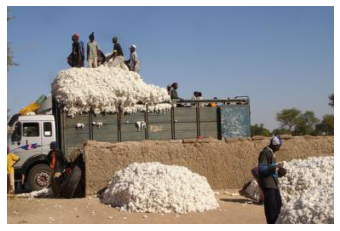

Predicted: ein mann mit einem auf einem dach . <END>
True: <start> <unk> mit lkw <end>
1


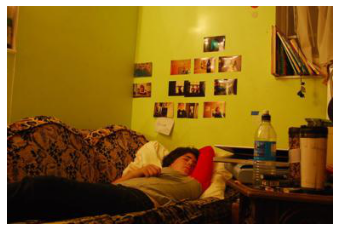

Predicted: ein mann und eine frau sitzen an einem tisch und spielen ein brettspiel . <END>
True: <start> ein mädchen schläft auf dem sofa . <end>
2


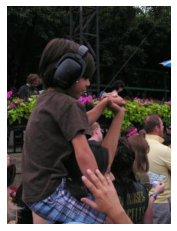

Predicted: ein mädchen mit rosa haarreif und rosa shirt sitzt auf einer wiese und schaut auf ein handy . <END>
True: <start> ein kind hört musik auf den kopfhörern . <end>
3


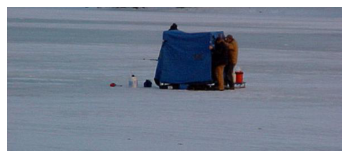

Predicted: ein mann und eine frau sitzen am strand und schauen aufs meer . <END>
True: <start> zelten auf dem eis <end>
4


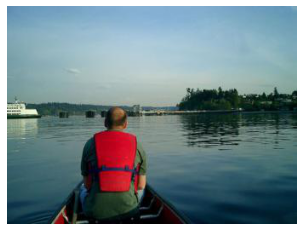

Predicted: ein mann mit roter jacke und sonnenbrille sitzt auf einem boot und angelt . <END>
True: <start> ein mann fährt einsam auf einem see . <end>
5


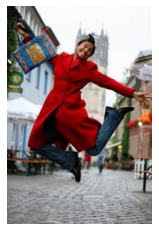

Predicted: ein mann in rotem shirt und roter jacke steht auf einem platz und hält sich die hände vor den mund . <END>
True: <start> eine frau freut sich und springt <end>
6


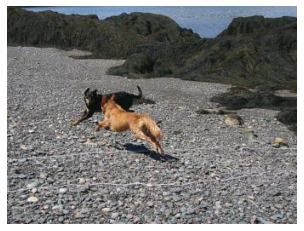

Predicted: ein hund läuft über einen strand . <END>
True: <start> ein schwarzer und ein brauner hund rennen auf steinigem boden aufeinander zu . <end>
7


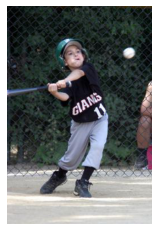

Predicted: ein junge in weißem shirt und jeans steht auf einem spielfeld und hält einen schläger in der hand . <END>
True: <start> ein kind beim baseball beim schlag <end>
8


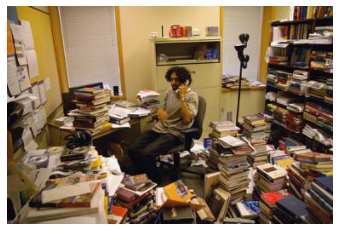

Predicted: eine frau sitzt in einem büro und liest ein buch . <END>
True: <start> ein mann der zwischen bergen aus büchern sitzt und dabei telefoniert . <end>
9


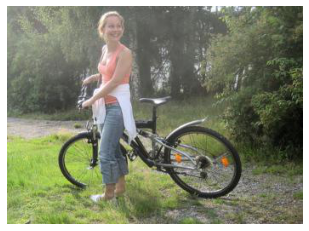

Predicted: ein junge fährt mit seinem fahrrad auf einer straße . <END>
True: <start> frau mit fahrrad auf einer wiese <end>
10


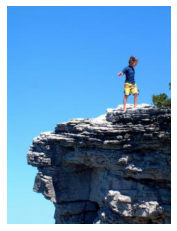

Predicted: ein mann klettert auf einem felsen . <END>
True: <start> eine junge steht auf einem felsen . <end>
11


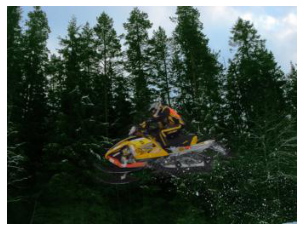

Predicted: zwei personen fahren mit einem schlauchboot durch einen wald . <END>
True: <start> ein snowboarder bei einem sprung vor tannenbäumen <end>
12


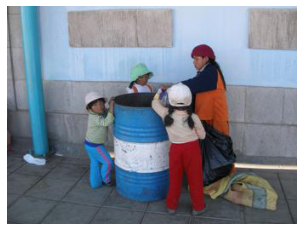

Predicted: zwei männer mit und schlafsäcken stehen vor einem haus . <END>
True: <start> eine frau und drei kinder <unk> müll . <end>
13


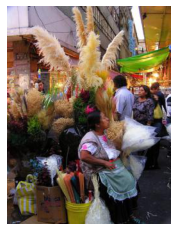

Predicted: eine gruppe von menschen sitzt auf einem weg . <END>
True: <start> menschen in der bunten ladenpassage <end>
14


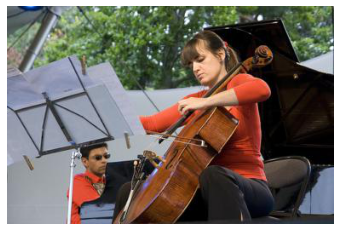

Predicted: ein mann spielt auf einer geige . <END>
True: <start> eine weibliche person spielt auf einem instrument . <end>
15


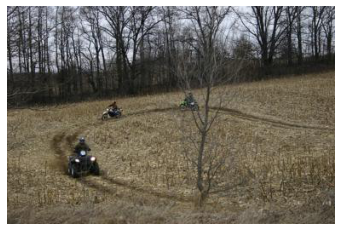

Predicted: ein mann fährt auf einem fahrrad auf einer wiese . <END>
True: <start> ein quad und zwei motorräder fahren auf einer <unk> <end>
16


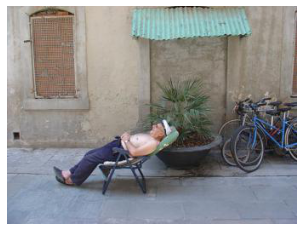

Predicted: ein mann sitzt auf einer bank und liest ein buch . <END>
True: <start> sich <unk> mann auf der liege <end>
17


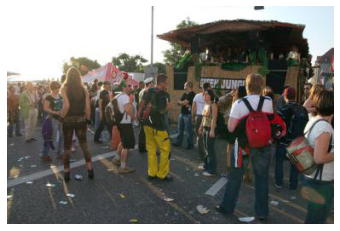

Predicted: ein paar personen , die auf einem platz gehen . <END>
True: <start> eine gruppe menschen machen party auf der straße . <end>
18


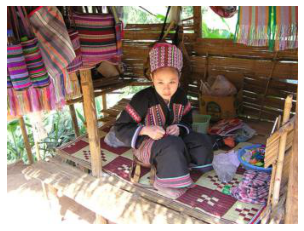

Predicted: zwei frauen sitzen in einem restaurant . <END>
True: <start> traditionell bekleidete frau sitzt in einer hütte vor <unk> stoffen . <end>
19


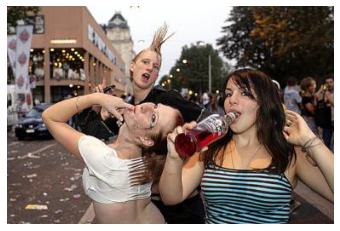

Predicted: eine frau und ein mann mit masken und . <END>
True: <start> ein paar jugendliche trinken alkohol auf der straße . <end>
20


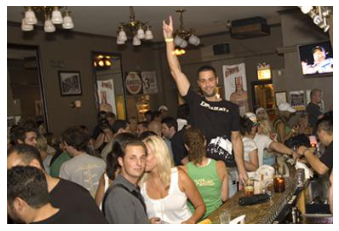

Predicted: eine gruppe menschen sitzt zusammen und unterhalten sich . <END>
True: <start> die leute trinken im kneipe . <end>
21


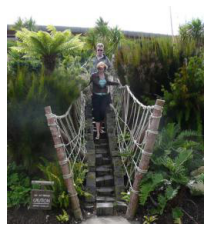

Predicted: ein über eine brücke . <END>
True: <start> ein pärchen auf einer hängebrücke <end>
22


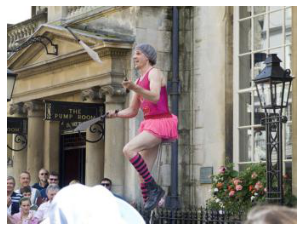

Predicted: eine frau mit rotem shirt und schwarzer hose geht auf einem gehweg an einer mauer entlang . <END>
True: <start> mann jongliert <unk> <end>
23


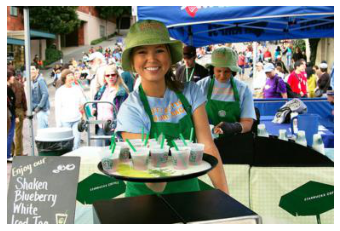

Predicted: eine frau und ein mann sitzen an einem tisch und essen . <END>
True: <start> junge frau <unk> auf tablett tee an <end>
24


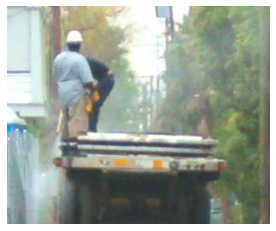

Predicted: ein mann mit helm steht auf einer leiter und arbeitet an einer maschine . <END>
True: <start> zwei männer stehen auf einem transporter . <end>
25


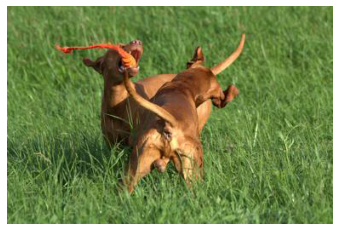

Predicted: zwei hunde rennen über eine wiese . <END>
True: <start> 2 hunde beim spielen auf einer wiese <end>
26


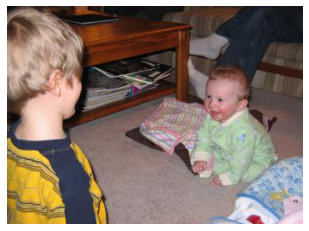

Predicted: ein kleiner junge mit einem kleinen jungen auf dem schoss hat . <END>
True: <start> <unk> mit baby im zimmer <end>
27


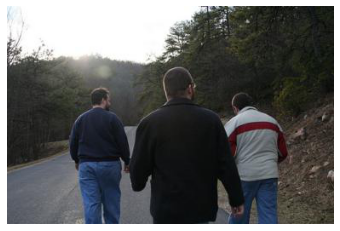

Predicted: zwei männer stehen auf einer straße und unterhalten sich . <END>
True: <start> drei männer gehen auf einer straße wobei man nur den <unk> sieht . <end>
28


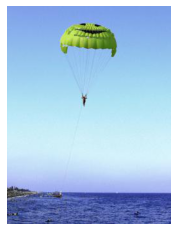

Predicted: ein paragleiter mit bunten ballons . <END>
True: <start> ein grüner fallschirm wird hinter einem boot <unk> . <end>
29


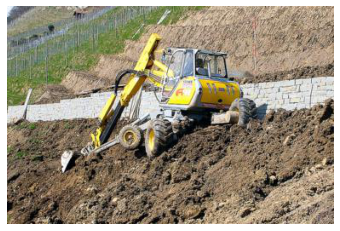

Predicted: ein motocrossfahrer fährt durch den matsch . <END>
True: <start> ein bagger arbeitet auf einer schräge <end>


In [46]:
import matplotlib.pyplot as plt

# Create dataset classes for training and validation.
testset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                           'val', config.language, config.max_vocabulary_size,
                           cache_path = config.cache_path, overwrite_cache = True)

# No need to use GPU for this part, make sure it is turned off.
image_captioner =  image_captioner.cpu()

for i in range(0,30):
    print(i)
    image, text = testset[i*5]
    caption = generate_caption(image_captioner, image)

    plt.figure(); plt.imshow(image); plt.axis('off');plt.show()
    print("Predicted: {}".format(caption))
    print("True: {}".format(" ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in text.tolist()])))

### **3. Image Synthesis [2pts]**

A core technology in many modern image synthesis models is to train an image auto-encoder, that is a model that given an input image, it can encode the image into a vector or sets of vectors, and then decode the same image. In this part of the assignment we will implement a very simple autoencoder that is trained on a single example.


#### **3.1 Autoencoding [2pt]**

Encode the image of the cat using a convolutional neural network, and decode the output of this convolutional neural network into a tensor of the same size as the input tensor image. Then train the network using the identity function so that it predicts the input image as output. Just to be clear I am asking you to define this neural network and then train it with a single image example so that it predicts its own input as faithfully as possible. The network doesn't need to generalize to other images, it is sufficient that it does its job for the single image of the black-cat. An example output is shown below, the quality of the output reconstruction will depend on your design choice of the auto-encoder neural network and your choices in the optimization of this network.

Epoch [1/1000], Loss: 0.0487
Epoch [101/1000], Loss: 0.0154
Epoch [201/1000], Loss: 0.0065
Epoch [301/1000], Loss: 0.0056
Epoch [401/1000], Loss: 0.0052
Epoch [501/1000], Loss: 0.0050
Epoch [601/1000], Loss: 0.0049
Epoch [701/1000], Loss: 0.0048
Epoch [801/1000], Loss: 0.0046
Epoch [901/1000], Loss: 0.0044


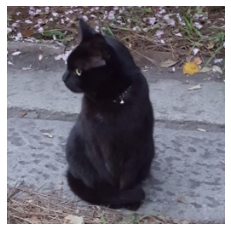

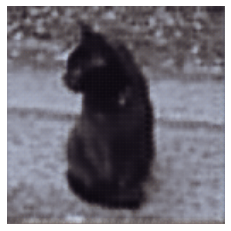

In [11]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import json, io, requests, string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class MyAutoEncoder(nn.Module):
  def __init__(self):
    super(MyAutoEncoder, self).__init__()
    # Layer definitions.
    self.encoder = nn.Sequential(
        #input = 3*256*256
        nn.Conv2d(3, 16, kernel_size=3, padding=1), 
        nn.ReLU(),
        #input = 16 * 256 * 256
        nn.AvgPool2d(kernel_size=2, stride=2),
        #input = 16 * 128 * 128
        nn.Conv2d(16, 8, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        #input = 8 * 64 * 64
        nn.Conv2d(8, 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder
    self.decoder = nn.Sequential(
        #input = 8 * 64 * 64
        nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
        )

  def forward(self, x):
    # Forward pass definitions.
    x = self.encoder(x)
    # Decoder
    x = self.decoder(x)
    return x
preprocessFn = transforms.Compose(
    [transforms.Resize((256, 256)), transforms.ToTensor()])

img_url = 'http://www.cs.rice.edu/~vo9/vision/black-cat.jpg'
response = requests.get(img_url)
img_pil = Image.open(io.BytesIO(response.content))
inputVar =  preprocessFn(img_pil).unsqueeze(0)

# Create an instance of the autoencoder and set up the optimizer and loss function
autoencoder = MyAutoEncoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Train the autoencoder with the identity function
for epoch in range(1000):
    # Forward pass
    output = autoencoder(inputVar)
    loss = loss_func(output, inputVar)
    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 1000, loss.item()))


autoencoder.eval(); 


# Train the network.

pred = autoencoder(inputVar)

# Show Predictions.
plt.figure()
plt.imshow(inputVar.clone().squeeze().permute(1, 2, 0)); plt.grid('off'); plt.axis('off');
plt.show()
plt.figure()
plt.imshow(pred.detach().clone().squeeze().permute(1, 2, 0)); plt.grid('off'); plt.axis('off');
plt.show()